# Robot Reviews
Sentiment Classification Model

In [1]:
import os
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from peft import LoraConfig, TaskType, get_peft_model
from sklearn import metrics, model_selection, utils
from transformers import (DistilBertForSequenceClassification, DistilBertTokenizer,
                          Trainer, TrainingArguments)


2024-10-17 18:43:14.270589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 18:43:14.270645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 18:43:14.271672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 18:43:14.277477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 18:43:15.034568: W tensorflow/compiler/tf2

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running Fold 1


Epoch,Training Loss,Validation Loss
1,0.684500,0.554081
2,0.531200,0.465921
3,0.494000,0.411127
4,0.320100,0.379603
5,0.406300,0.367892


Running Fold 2


Epoch,Training Loss,Validation Loss
1,0.440200,0.283657
2,0.319600,0.236399
3,0.274800,0.205519
4,0.320700,0.192756
5,0.208700,0.189059


Running Fold 3


Epoch,Training Loss,Validation Loss
1,0.299100,0.143417
2,0.185000,0.124396
3,0.194600,0.118458
4,0.221200,0.110115
5,0.249500,0.107874


Avg Accuracy: 0.9222
Avg Precision: 0.9229
Avg Recall: 0.9222
Avg F1: 0.9222


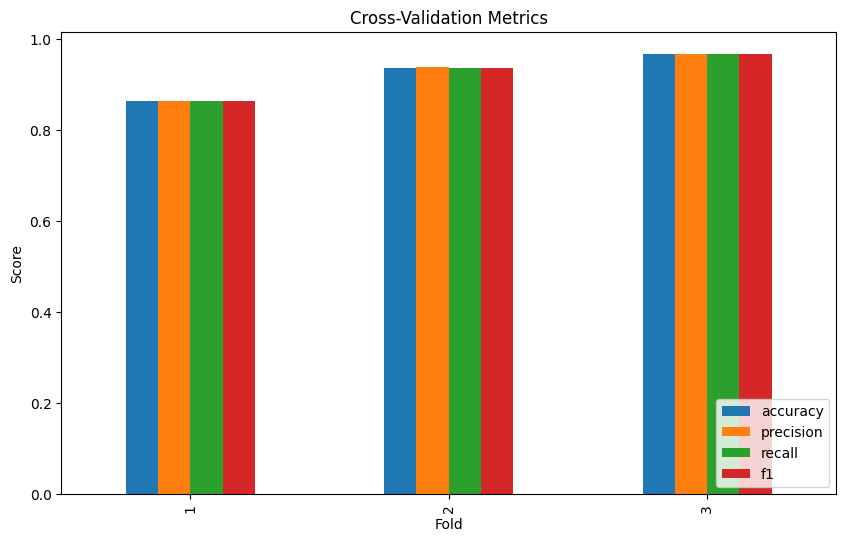

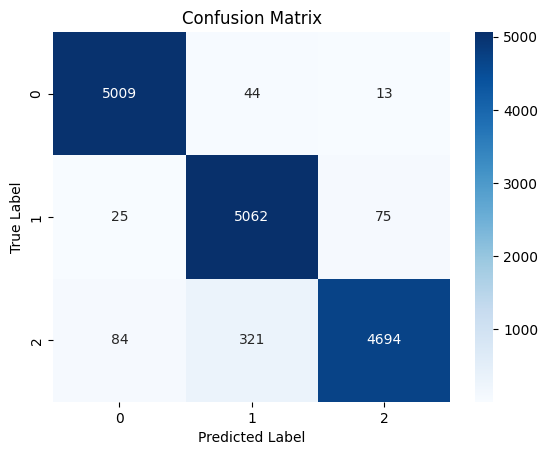

In [2]:
# Constants
FILE_PATH = '/notebooks/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
COLUMNS_TO_KEEP = ['name', 'brand', 'primaryCategories', 'reviews.text', 'reviews.rating']
RANDOM_STATE = 42
MAX_LENGTH = 512
NUM_LABELS = 3
NUM_FOLDS = 3

os.environ["WANDB_DISABLED"] = "true"  # Disable WandB

# Data Loading and Preprocessing
def load_and_preprocess_data(file_path: str, columns: List[str]) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    return df[columns]

def balance_dataset(df: pd.DataFrame) -> pd.DataFrame:
    positive_reviews = df[df['reviews.rating'] >= 4]
    neutral_reviews = df[df['reviews.rating'] == 3]
    negative_reviews = df[df['reviews.rating'] <= 2]

    max_class_size = max(len(positive_reviews), len(neutral_reviews), len(negative_reviews))
    
    positive_upsampled = utils.resample(positive_reviews, replace=True, n_samples=max_class_size, random_state=RANDOM_STATE)
    neutral_upsampled = utils.resample(neutral_reviews, replace=True, n_samples=max_class_size, random_state=RANDOM_STATE)
    negative_upsampled = utils.resample(negative_reviews, replace=True, n_samples=max_class_size, random_state=RANDOM_STATE)

    df_balanced = pd.concat([positive_upsampled, neutral_upsampled, negative_upsampled]).sample(frac=1, random_state=RANDOM_STATE)
    df_balanced['labels'] = df_balanced['reviews.rating'].map(lambda rating: 0 if rating <= 2 else (1 if rating == 3 else 2))
    
    return df_balanced

def prepare_datasets(df: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    return model_selection.train_test_split(
        df['reviews.text'], df['labels'], test_size=0.2, random_state=RANDOM_STATE
    )

def tokenize_data(tokenizer, texts, max_length=MAX_LENGTH):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

def create_hf_dataset(encodings, labels):
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'].tolist(),
        'attention_mask': encodings['attention_mask'].tolist(),
        'labels': labels.tolist()
    })

# Model Setup
def setup_model_and_trainer(num_labels, lora_config, training_args, train_dataset):
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
    model = get_peft_model(model, lora_config)
    return Trainer(model=model, args=training_args, train_dataset=train_dataset)

def run_cross_validation(trainer, X_train, y_train, tokenizer, n_splits=NUM_FOLDS):
    kf = model_selection.KFold(n_splits=n_splits)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Running Fold {fold + 1}")

        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        fold_train_encodings = tokenize_data(tokenizer, X_fold_train)
        fold_val_encodings = tokenize_data(tokenizer, X_fold_val)

        fold_train_dataset = create_hf_dataset(fold_train_encodings, y_fold_train)
        fold_val_dataset = create_hf_dataset(fold_val_encodings, y_fold_val)

        trainer.train_dataset = fold_train_dataset
        trainer.eval_dataset = fold_val_dataset

        trainer.train()
        predictions = trainer.predict(fold_val_dataset)
        preds = np.argmax(predictions.predictions, axis=1)

        fold_metrics.append({
            'fold': fold + 1,
            'accuracy': metrics.accuracy_score(y_fold_val, preds),
            'precision': metrics.precision_score(y_fold_val, preds, average='weighted'),
            'recall': metrics.recall_score(y_fold_val, preds, average='weighted'),
            'f1': metrics.f1_score(y_fold_val, preds, average='weighted')
        })

    return fold_metrics

def main():
    df = load_and_preprocess_data(FILE_PATH, COLUMNS_TO_KEEP)
    df_balanced = balance_dataset(df)
    X_train, X_test, y_train, y_test = prepare_datasets(df_balanced)

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    train_encodings = tokenize_data(tokenizer, X_train)
    train_dataset = create_hf_dataset(train_encodings, y_train)

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["q_lin", "v_lin"]
    )

    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=1,
        no_cuda=False
    )

    trainer = setup_model_and_trainer(NUM_LABELS, lora_config, training_args, train_dataset)
    fold_metrics = run_cross_validation(trainer, X_train, y_train, tokenizer)

    avg_metrics = {metric: np.mean([f[metric] for f in fold_metrics]) 
                   for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    for metric, value in avg_metrics.items():
        print(f"Avg {metric.capitalize()}: {value:.4f}")
    
        # Plot metrics
    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df = metrics_df.set_index('fold')
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Cross-Validation Metrics')
    plt.ylabel('Score')
    plt.xlabel('Fold')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion matrix
    y_pred = trainer.predict(create_hf_dataset(tokenize_data(tokenizer, X_test), y_test)).predictions.argmax(axis=1)
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



if __name__ == "__main__":
    main()


Make predictions with Testing Set

In [5]:
# Constants
TEST_FILE_PATH = '/notebooks/Testing Set.csv'
MAX_LENGTH = 512
NUM_LABELS = 3

def load_test_data(file_path):
    df = pd.read_csv(file_path)
    return df['reviews.text'], df['labels']

def tokenize_data(tokenizer, texts, max_length=MAX_LENGTH):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

def create_hf_dataset(encodings, labels):
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'].tolist(),
        'attention_mask': encodings['attention_mask'].tolist(),
        'labels': labels.tolist()
    })

def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': metrics.accuracy_score(y_true, y_pred),
        'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
        'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
        'f1': metrics.f1_score(y_true, y_pred, average='weighted')
    }

def plot_confusion_matrix(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_metrics(metrics_dict):
    plt.figure(figsize=(10, 6))
    plt.bar(metrics_dict.keys(), metrics_dict.values())
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for i, v in enumerate(metrics_dict.values()):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
    plt.show()

def main():
    # Load the test data
    X_test, y_test = load_test_data(TEST_FILE_PATH)

    # Load the pre-trained tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('./results')

    # Tokenize the test data
    test_encodings = tokenize_data(tokenizer, X_test)
    test_dataset = create_hf_dataset(test_encodings, y_test)

    # Make predictions
    model.eval()
    predictions = model(test_dataset['input_ids'], attention_mask=test_dataset['attention_mask'])
    y_pred = np.argmax(predictions.logits.detach().numpy(), axis=1)

    # Calculate metrics
    result_metrics = calculate_metrics(y_test, y_pred)
    print("Metrics:")
    for metric, value in result_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    # Calculate loss
    loss = predictions.loss.item()
    print(f"Loss: {loss:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    # Plot metrics
    plot_metrics(result_metrics)

if __name__ == "__main__":
    main()

NameError: name 'trainer' is not defined

Saving the model

In [ ]:
# Save the final model and tokenizer after all cross-validation and training is done
output_dir = r"C:\Users\fmrol\Documents\GitHub\RobotReviews\fredsmeds_classifier"
trainer.save_model(output_dir)  # Save the fine-tuned model
tokenizer.save_pretrained(output_dir)  # Save the tokenizer

print(f"Final model and tokenizer saved to {output_dir}")
